In [92]:
import os, sys

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
from scipy import interpolate


In [94]:
data_dir = "../data/2022-11-22"

In [95]:
dirnames = os.listdir(data_dir)
dirnames = list(os.path.join(data_dir, f) for f in dirnames)

fnames = []

for dirname in dirnames:
    files = os.listdir(dirname)
    for file in files:
        if ".dat" in file:
            fnames.append(f"{dirname}/{file}")
            print(file)

frq_data.dat
frq_data.dat
characterization_data.dat
frq_data.dat
characterization_data.dat
frq_data.dat
frq_data.dat
frq_data.dat


In [96]:
data = []
init_length = 300
for fname in fnames:
    dat = pd.read_csv(fname)
    dat["t"] = dat["T_(ms)"]/1000 #ms to s
    #dat["y"] = 90.08745-((dat["V_dist_(mA)"]-4)/16)*101.60 #convert milliamp to millimeters
    dat["y"] = 101.60-(dat["V_dist_(mA)"]-4)*101.60/16 - 7.5 #convert milliamp to millimeters
    dat["strain"] = (init_length-dat["y"])/init_length
    dat["p_c"] = (dat["Comp_P_(mA)"]-4)*0.75
    dat["v"] = dat["Sys_Volts_(V)"]
    dat["l"] = dat["LC_(grams)"]
    dat["p_p"] = (dat["Piezo_P_(mA)"]-4)*0.75
    dat["p_o"] = 6*(dat["Piezo_out_(mV)"]-4000)/16000 #converting milliamp output to expected bar output
    dat.style.set_caption(fname.split('/')[-1].split('.')[0])
    data.append(dat)

In [97]:
def plot_test(df):
    fig, axes = plt.subplots(4,1, sharex=True, figsize=(15,10))
    axes[0].plot(df["t"], df["y"],linestyle='None',marker='o',markersize=1)
    axes[0].plot(0, 0,linestyle='None',marker='o',markersize=0.5, color='r')
    axes[0].grid()
    axes[0].set_ylabel("Distance (mm)", fontsize=14)
    shared_x_load = axes[0].twinx()
    shared_x_load.plot(df["t"], df["l"]/1000,linestyle='None',marker='o',markersize=0.5,color='r')
    shared_x_load.set_ylabel("Load (kg)", fontsize=14)
    axes[0].legend(["Vertical Distance", "Load"],loc='upper right')
    axes[1].plot(df["t"], df["p_o"],linestyle='None',marker='o',markersize=0.5)
    axes[1].grid()
    axes[1].plot(df["t"], df["p_p"],linestyle='None',marker='o',markersize=0.5)
    axes[1].set_ylabel("Pressure - Actuator \n(Bar)", fontsize=14)
    axes[1].set_ylim([-0.25, 7])
    axes[1].legend(["Pressure Out","Pressure Gauge"])
    axes[2].plot(df["t"], df["p_c"],linestyle='None',marker='o',markersize=0.5)
    axes[2].grid()
    axes[2].set_ylim([-0.25, 7])
    axes[2].set_ylabel("Pressure - Comp. \n(Bar)", fontsize=14)

    axes[3].plot(df["t"], df["v"],linestyle='None',marker='o',markersize=0.5)
    axes[3].grid()
    axes[3].set_ylabel("System (V)", fontsize=14)
    
    axes[3].set_xlabel("Time (s)", fontsize=14)
    supply_frq = 2*np.pi/df['t'].iloc[find_peaks(df['p_o'])[0]].diff().mean()
    center_val = df['p_o'].mean()
    amp = abs(df['p_o'] - center_val).max()
    plt.suptitle("Time Series Data from System Characterization", fontsize=24)
    plt.subplots_adjust(top=0.935, left=0.1, right=0.9, bottom=0.1)
    fig.patch.set_facecolor([1,1,1])

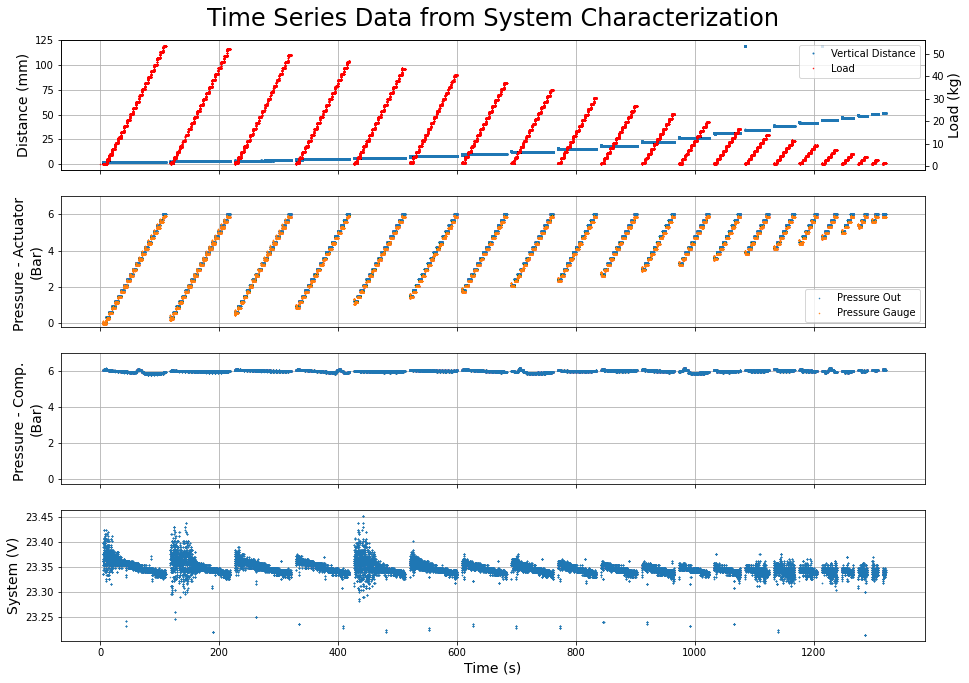

In [71]:
plot_test(data[4])
plt.savefig("figures/timeseries_data_characterization.jpg", dpi=300)

In [29]:
#bin the data to the nearest pressure
fine_char_data = data[4]
coarse_char_data = data[2]
p_bin_size = 0.5 #bar
fine_char_data['p_p_bin'] = round(fine_char_data['p_p']/p_bin_size)*p_bin_size
coarse_char_data['p_p_bin'] = round(coarse_char_data['p_p']/p_bin_size)*p_bin_size

In [30]:
#extract data for each bin of data
binned_pressure_data_fine = dict()
for pressure in fine_char_data['p_p_bin'].unique():
    if pressure < 0:
        continue
    binned_pressure_data_fine.update({f"{pressure}":fine_char_data[fine_char_data['p_p_bin'] == pressure]})

In [31]:
#for each bin, we now bin/average the data w/rt strain
strain_bin_size = 0.01
load_bin = 1 #nearest kg
result = dict()
for key in binned_pressure_data_fine.keys():
    #we now bin the nearest strain 
    binned_pressure_data_fine[key]['strain_appx'] = round(round(binned_pressure_data_fine[key]['strain']/strain_bin_size,3)*strain_bin_size,3)
    #with these binned strains, those that have the same value but variations in load will be averaged
    binned_pressure_data_fine[key]['l_bin'] = round(round(((binned_pressure_data_fine[key]['l']/1000))/load_bin)*load_bin,3)
    result.update({key:{"strain":[], "load":[]}})
    for strain_bin in binned_pressure_data_fine[key]['strain_appx'].unique():
        if strain_bin < 0.8:
            continue
        result[key]["strain"].append(1-strain_bin)
        bl_idx = (binned_pressure_data_fine[key]['strain_appx'] == strain_bin)
        mean = binned_pressure_data_fine[key].loc[bl_idx]['l_bin'].mean()
        result[key]["load"].append(mean)
        #binned_pressure_data_fine[key][bl_idx]['l_mean'] = mean
        #print(binned_pressure_data_fine[key][bl_idx]['l_mean'].unique())

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/2233373312.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binned_pressure_data_fine[key]['strain_appx'] = round(round(binned_pressure_data_fine[key]['strain']/strain_bin_size,3)*strain_bin_size,3)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/2233373312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binned_pressure_data_fine[key]['l_bin'] = round(round(((binned_pressure_data_fine[key]['l']/1000))/load_bin)*load_bin

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/3122918251.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([f"{lab:0.3f}" for lab in labels], fontsize=14, rotation=45)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/3122918251.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)


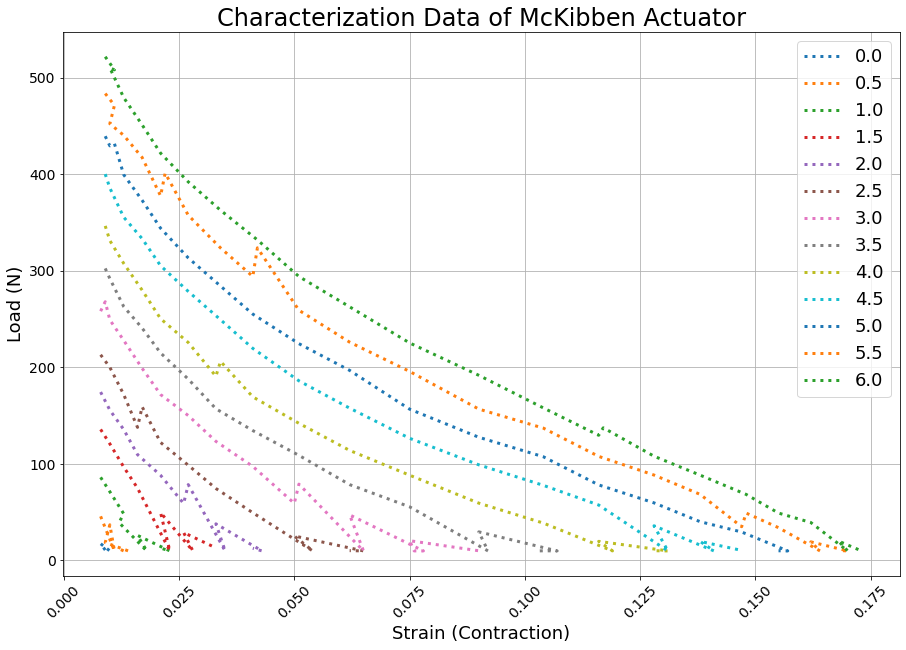

In [69]:

fig, axes = plt.subplots(figsize=(15,10))
for idx, key in enumerate(result.keys()):
    dat = np.array(result[key]['load'])*9.81
    axes.plot(np.array(result[key]['strain']), dat,linestyle=":", linewidth=3)
axes.legend(result.keys(), fontsize=18)
axes.set_ylabel("Load (N)", fontsize=18)
axes.set_xlabel("Strain (Contraction)", fontsize=18)
labels = axes.get_xticks()
axes.set_xticklabels([f"{lab:0.3f}" for lab in labels], fontsize=14, rotation=45)
labels = axes.get_yticks()
axes.set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)
axes.set_title("Characterization Data of McKibben Actuator", fontsize=24)
axes.grid()
plt.savefig("figures/characterization_results.jpg", dpi=600)

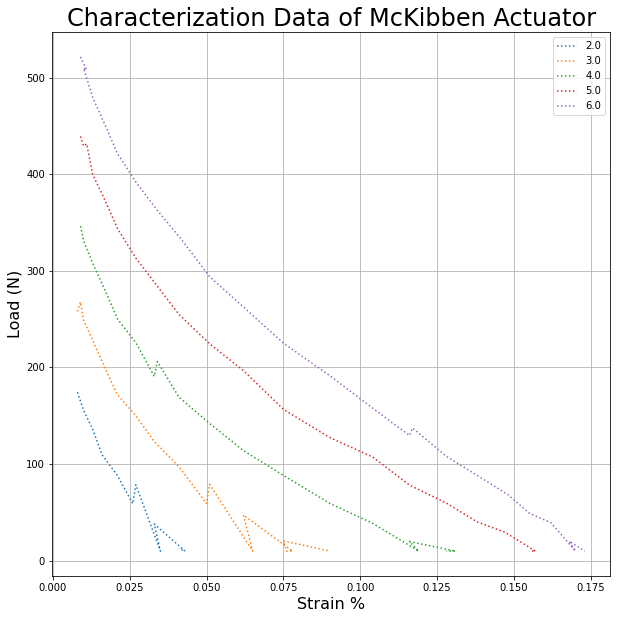

In [53]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(figsize=(10,10))
keys = ["2.0", "3.0", "4.0", "5.0", "6.0"]
for idx, key in enumerate(keys):
    dat = np.array(result[key]['load'])*9.81
    #win_size = 6 if len(dat) < 15 else 15
    #dat = savgol_filter(dat, win_size, 3)
    axes.plot(np.array(result[key]['strain']), dat,linestyle=":")
axes.legend(keys)
axes.set_ylabel("Load (N)", fontsize=16)
axes.set_xlabel("Strain %", fontsize=16)
axes.set_title("Characterization Data of McKibben Actuator", fontsize=24)
axes.grid()

In [75]:
import math
from scipy.interpolate import pchip_interpolate as pch

#Demo referencing specs from datasheet

C_q1 = 3 #unitless, referencing kang's paper for ballpark region estimate
C_q2 = -0.000002 #unitless
q = lambda P: 1 + C_q1 * np.exp(C_q2*P) #q correction factor

L_a = 0.30 #meters
eps = lambda L: (L_a - L)/(L_a) #strain

alpha_0 = 23*np.pi/180 #degrees to radians

D_0 = 0.010 #meters
C_1 = (np.pi*D_0**2)/(4.0)
C_2 = (3)/(np.tan(alpha_0)**2)
C_3 = (1)/(np.sin(alpha_0)**2)
C_4 = C_1*C_2
C_5 = C_1*C_3 


L_fpdf = L_a * 0.9 #length for complementary percent of deformation
def f_a(P, L):
    return P*C_4*(1+(q(P)**2)*(eps(L)**2) - 2*q(P)*eps(L)) - P*C_5

f_a(800000, L_fpdf)
pressures = np.arange(0, 8+1, 1)*100000 #bar to pa
strain = np.linspace(0, 20, 100)/100 #percent to decimal strain
lengths = L_a - L_a*strain


/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/1464923390.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([f"{lab:0.3f}" for lab in labels], fontsize=14, rotation=45)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/1464923390.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)


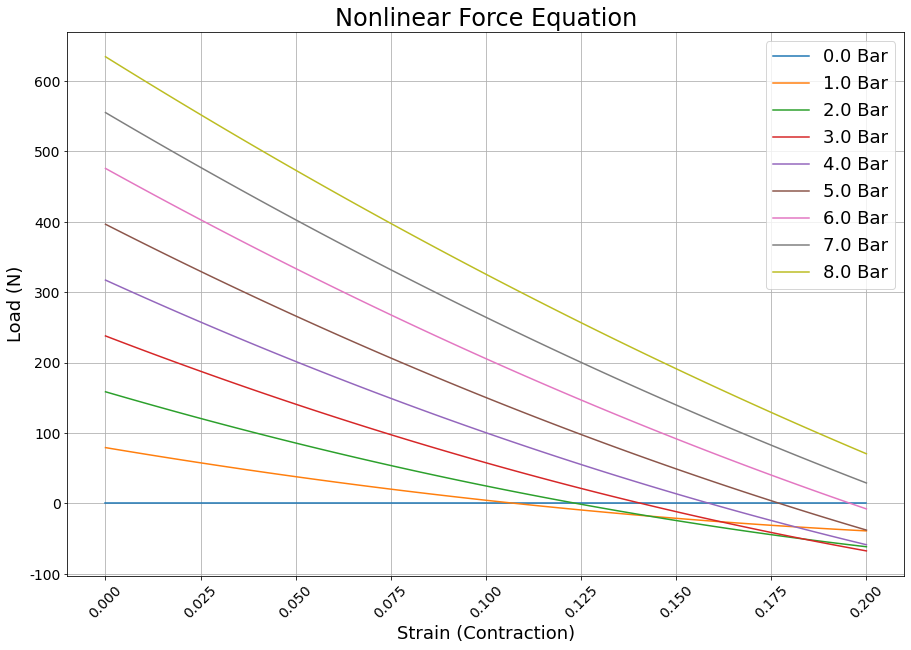

In [82]:
"""
fig, axis = plt.subplots(figsize=(15,10))
for pressure in pressures:
  forces = f_a(pressure, lengths)
  axis.plot(strain, forces)
axis.set_xlabel("Strain", fontsize=14)
axis.set_ylabel("Force", fontsize=14)
axis.set_title("Theoretical Force Equation", fontsize=24)
axis.grid()

"""

fig, axes = plt.subplots(figsize=(15,10))
for pressure in pressures:
    forces = f_a(pressure, lengths)
    axes.plot(strain, forces)
#axes.legend(result.keys(), fontsize=18)
axes.set_ylabel("Load (N)", fontsize=18)
axes.set_xlabel("Strain (Contraction)", fontsize=18)
axes.legend([f"{p/100000:0.1f} Bar" for p in pressures], fontsize=18)
labels = axes.get_xticks()
axes.set_xticklabels([f"{lab:0.3f}" for lab in labels], fontsize=14, rotation=45)
labels = axes.get_yticks()
axes.set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)
axes.set_title("Nonlinear Force Equation", fontsize=24)
axes.grid()
plt.savefig("figures/nlin_force_equation.jpg", dpi=600)

In [83]:
pesto_datasheet = dict() #for 8, 6, and 4 bar respectively

strain_6 = np.array([0, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22, 25])/100
bar_6 = [500, 300, 250, 200, 140, 100, 60, 30, 0, -50]
#interpolated = pch(strain_6, bar_6, strain)
f = interpolate.interp1d(strain_6, bar_6)
interpolated = f(strain)
pesto_datasheet.update({"6bar":interpolated})

strain_4 = np.array([0, 5, 10, 15, 20, 25])/100
bar_4 = [350, 175, 90, 25, -50, -100]
#interpolated = pch(strain_4, bar_4, strain)
f = interpolate.interp1d(strain_4, bar_4)
interpolated = f(strain)
pesto_datasheet.update({"4bar":interpolated})

strain_2 = np.array([0, 2, 4, 5, 7])/100
bar_2 = [175, 100, 40, 25, 0]
#interpolated = pch(strain_2, bar_2, strain[strain < 0.10])
f = interpolate.interp1d(strain_2, bar_2)
interpolated = f(strain[strain < 0.07])
pesto_datasheet.update({"2bar":interpolated})

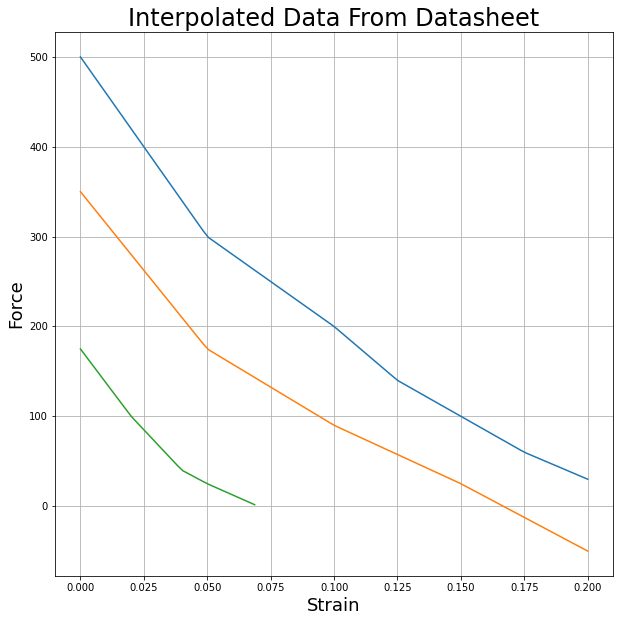

In [84]:
fig, axis = plt.subplots(figsize=(10,10))
for key, elem in pesto_datasheet.items():
  if key == "2bar":
    axis.plot(strain[strain < 0.07], elem)
  else:
    axis.plot(strain, elem)
axis.set_xlabel("Strain", fontsize=18)
axis.set_ylabel("Force", fontsize=18)
axis.set_title("Interpolated Data From Datasheet", fontsize=24)
axis.grid()

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/3978264608.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([f"{lab:0.3f}" for lab in labels], fontsize=14, rotation=45)
/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_97109/3978264608.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)


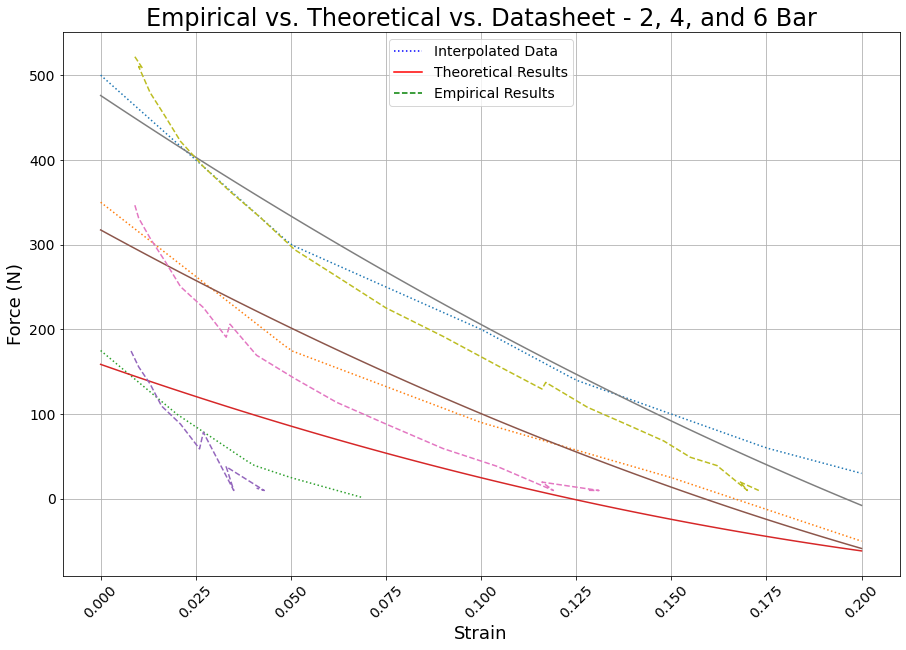

In [91]:
fig, axis = plt.subplots(figsize=(15,10))
from matplotlib.lines import Line2D as ps_p #pseudopoint
for key, elem in pesto_datasheet.items():
    if key == "2bar":
        axis.plot(strain[strain < 0.07], elem,linestyle=":")
    else:
        interp = axis.plot(strain, elem,linestyle=":")

                      
pselect = [200000, 400000, 600000]
            
pselect_exp = [f"{elem:.1f}" for elem in (np.array(pselect)/100000)]
for pressure in pselect:
    forces = f_a(pressure, lengths)
    theo = axis.plot(strain, forces, linestyle="-")
    accessor = f"{pressure/100000:.1f}"
    dat = np.array(result[accessor]['load'])*9.81   
    empi = axis.plot(result[accessor]['strain'], dat, linestyle="--")
    
axis.set_xlabel("Strain", fontsize=18)
axis.set_ylabel("Force (N)", fontsize=18)
axis.set_title("Empirical vs. Theoretical vs. Datasheet - 2, 4, and 6 Bar", fontsize=24)
axis.grid()
symbols = [ps_p([0],[0],
              color='b',
              label="Interpolated Data",
              linestyle=':'),
           ps_p([0],[0],
              color='r',
              label="Theoretical Results",
              linestyle='-'),
           ps_p([0],[0],
              color='g',
              label="Empirical Results",
              linestyle='--'),
          ]

axis.legend(handles=symbols, 
                      loc='upper center', 
                      fontsize=14,
                      ncol=1)
labels = axis.get_xticks()
axis.set_xticklabels([f"{lab:0.3f}" for lab in labels], fontsize=14, rotation=45)
labels = axis.get_yticks()
axis.set_yticklabels([f"{lab:0.0f}" for lab in labels], fontsize=14)
plt.savefig("figures/etd_2-4-6-bar.jpg", dpi=300)